# **Deep Fake Voice Recognition**

# Import all Needed Libraries

In [85]:
#To upload data zipfile
from google.colab import files
import zipfile
import os
import numpy as np

#To load and read file
import pandas as pd

#To encode LABEL Column
from sklearn.preprocessing import LabelEncoder

#To split data into training and testing sets
from sklearn.model_selection import train_test_split

#To scale data
from sklearn.preprocessing import RobustScaler

In [86]:
#To build the model
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss

#To plot the loss curves
import matplotlib.pyplot as plt

#To predict label of new audio
import librosa
import joblib

In [87]:
#Grid Search in hyperparameter tuning
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import make_pipeline

In [88]:
#LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

In [89]:
#Transfer Learning
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, models

#Load Data

Load the csv file containing extracted features & unzip it

In [90]:
uploaded_csv = files.upload()

zip_path = list(uploaded_csv.keys())[0]
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

Saving dataset.zip to dataset (1).zip


Read the csv file & Display its information

In [91]:
csv_path = '/content/DATASET-balanced.csv'
df = pd.read_csv(csv_path)

# Display the first few rows of the DataFrame
print(df.head())

# Count the number of rows for each label
label_counts = df['LABEL'].value_counts()
print(label_counts)

   chroma_stft       rms  spectral_centroid  spectral_bandwidth      rolloff  \
0     0.338055  0.027948        2842.948867         4322.916759  6570.586186   
1     0.443766  0.037838        2336.129597         3445.777044  3764.949874   
2     0.302528  0.056578        2692.988386         2861.133180  4716.610271   
3     0.319933  0.031504        2241.665382         3503.766175  3798.641521   
4     0.420055  0.016158        2526.069123         3102.659519  5025.077899   

   zero_crossing_rate       mfcc1       mfcc2      mfcc3      mfcc4  ...  \
0            0.041050 -462.169586   90.311272  19.073769  24.046888  ...   
1            0.047730 -409.413422  120.348808  -7.161531   5.114784  ...   
2            0.080342 -318.996033  120.490273 -24.625771  23.891073  ...   
3            0.047180 -404.636749  136.320908   2.308172  -3.907071  ...   
4            0.051905 -410.497925  152.731400 -18.266771  51.993462  ...   

     mfcc12    mfcc13    mfcc14    mfcc15    mfcc16    mfcc17 

#Preprocessing Data

Checking for Null Values

In [92]:
print(df.isnull().sum())

chroma_stft           0
rms                   0
spectral_centroid     0
spectral_bandwidth    0
rolloff               0
zero_crossing_rate    0
mfcc1                 0
mfcc2                 0
mfcc3                 0
mfcc4                 0
mfcc5                 0
mfcc6                 0
mfcc7                 0
mfcc8                 0
mfcc9                 0
mfcc10                0
mfcc11                0
mfcc12                0
mfcc13                0
mfcc14                0
mfcc15                0
mfcc16                0
mfcc17                0
mfcc18                0
mfcc19                0
mfcc20                0
LABEL                 0
dtype: int64


Drop duplicated rows if there are any

In [93]:
df = df.drop_duplicates()

Encoding LABEL Column: 0 for FAKE and 1 for REAL

In [94]:
def label_encoder(column):
    le = LabelEncoder().fit(column)
    print(column.name, le.classes_)
    return le.transform(column)

df['LABEL_encoded'] = label_encoder(df['LABEL'])
print(df[['LABEL', 'LABEL_encoded']])

LABEL ['FAKE' 'REAL']
      LABEL  LABEL_encoded
0      FAKE              0
1      FAKE              0
2      FAKE              0
3      FAKE              0
4      FAKE              0
...     ...            ...
11773  REAL              1
11774  REAL              1
11775  REAL              1
11776  REAL              1
11777  REAL              1

[11778 rows x 2 columns]


#Splitting Data and Scaling the Sets

Defining X (feature) and Y (target) vectors

In [95]:
X = df.iloc[:, :-2].values
y = df['LABEL_encoded'].values

Scaling and Splitting the data into training(80%), validating(10%), and testing(10%) sets

In [96]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

scaler = RobustScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Training set size: 9422
Validation set size: 1178
Test set size: 1178


#Building the Model

Build the MLPClassifier model & Train it on training and validating sets

In [97]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=( 64, 32),
                               max_iter=100,
                               solver='adam',
                               learning_rate_init=0.001,
                               alpha=0.001,
                               validation_fraction=0.2,
                               random_state=42)

# To store training and validation values
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# To track the best validation accuracy and corresponding weights
best_val_accuracy = 0
best_weights = None
best_intercepts = None

n_iterations = 100

for i in range(n_iterations):
    mlp_classifier.partial_fit(X_train_scaled, y_train, classes=np.unique(y_train))

    y_train_pred = mlp_classifier.predict(X_train_scaled)
    y_val_pred = mlp_classifier.predict(X_val_scaled)

    # Calculating training accuracy and loss
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_loss = log_loss(y_train, mlp_classifier.predict_proba(X_train_scaled))

    # Calculating validation accuracy and loss
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_loss = log_loss(y_val, mlp_classifier.predict_proba(X_val_scaled))

    # Storing the values
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Checking if this is best validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_weights = mlp_classifier.coefs_
        best_intercepts = mlp_classifier.intercepts_

    # Current iteration
    print(f"Iteration {i + 1}/{n_iterations} - "
          f"Train Accuracy: {train_accuracy:.4f}, "
          f"Train Loss: {train_loss:.4f}, "
          f"Validation Accuracy: {val_accuracy:.4f}, "
          f"Validation Loss: {val_loss:.4f}")

# After training, restore best weights and bias
if best_weights is not None:
    mlp_classifier.coefs_ = best_weights
    mlp_classifier.intercepts_ = best_intercepts

print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")

Iteration 1/100 - Train Accuracy: 0.8639, Train Loss: 0.3778, Validation Accuracy: 0.8531, Validation Loss: 0.3873
Iteration 2/100 - Train Accuracy: 0.9442, Train Loss: 0.2100, Validation Accuracy: 0.9312, Validation Loss: 0.2224
Iteration 3/100 - Train Accuracy: 0.9679, Train Loss: 0.1270, Validation Accuracy: 0.9635, Validation Loss: 0.1384
Iteration 4/100 - Train Accuracy: 0.9769, Train Loss: 0.0873, Validation Accuracy: 0.9703, Validation Loss: 0.0990
Iteration 5/100 - Train Accuracy: 0.9820, Train Loss: 0.0661, Validation Accuracy: 0.9737, Validation Loss: 0.0769
Iteration 6/100 - Train Accuracy: 0.9863, Train Loss: 0.0536, Validation Accuracy: 0.9779, Validation Loss: 0.0636
Iteration 7/100 - Train Accuracy: 0.9879, Train Loss: 0.0453, Validation Accuracy: 0.9796, Validation Loss: 0.0545
Iteration 8/100 - Train Accuracy: 0.9897, Train Loss: 0.0392, Validation Accuracy: 0.9813, Validation Loss: 0.0478
Iteration 9/100 - Train Accuracy: 0.9911, Train Loss: 0.0346, Validation Accurac

Make predictions on test set & Evaluate

In [98]:
predictions = mlp_classifier.predict(X_test_scaled)

test_accuracy = accuracy_score(y_test, predictions)
test_loss = log_loss(y_test, mlp_classifier.predict_proba(X_test_scaled))

print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

Test Accuracy: 0.9966, Test Loss: 0.0207


In [99]:
# Save the trained model
joblib.dump(mlp_classifier, 'mlp_classifier.pkl')

['mlp_classifier.pkl']

In [100]:
# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

#Hyper Parameter Tuning

Applying a grid search to find the best parameters (alpha, learning rate, max iterations)

In [101]:
# Create a pipeline with scaling and the MLPClassifier
pipeline = make_pipeline(RobustScaler(), MLPClassifier(hidden_layer_sizes=(64, 32), random_state=42))

# Define hyperparameter grid
param_grid = {
    'mlpclassifier__alpha': [0.0001, 0.001, 0.01],
    'mlpclassifier__learning_rate_init': [0.001, 0.01, 0.1],
    'mlpclassifier__max_iter': [150, 200, 250]
}

# Grid search with cross-validation on the training set
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Print the best parameters found
print("Best parameters found: ", grid_search.best_params_)

# Evaluate the best model on the validation set
val_predictions = best_model.predict(X_val)
print("Validation Set Performance:")
print(classification_report(y_val, val_predictions))

# Evaluate on the test set
test_predictions = best_model.predict(X_test)
best_test_accuracy = accuracy_score(y_test, test_predictions)
best_test_loss = log_loss(y_test, best_model.predict_proba(X_test))

print("Test Set Performance:")
print(classification_report(y_test, test_predictions))

Best parameters found:  {'mlpclassifier__alpha': 0.001, 'mlpclassifier__learning_rate_init': 0.01, 'mlpclassifier__max_iter': 150}
Validation Set Performance:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       589
           1       0.99      1.00      0.99       589

    accuracy                           0.99      1178
   macro avg       0.99      0.99      0.99      1178
weighted avg       0.99      0.99      0.99      1178

Test Set Performance:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       589
           1       0.99      1.00      1.00       589

    accuracy                           1.00      1178
   macro avg       1.00      1.00      1.00      1178
weighted avg       1.00      1.00      1.00      1178



Compare test accuracies and losses between First & Best Models to determine which is better

In [102]:
print(f"First Model Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")
print(f"Best Model Test Accuracy: {best_test_accuracy:.4f}, Test Loss: {best_test_loss:.4f}")

if best_test_accuracy > test_accuracy:
    print("The best model is better than the first model based on test accuracy.")
else:
    print("The first model is better than the best model based on test accuracy.")

First Model Test Accuracy: 0.9966, Test Loss: 0.0207
Best Model Test Accuracy: 0.9966, Test Loss: 0.0230
The first model is better than the best model based on test accuracy.


#Predict the Label of a New Audio

Split a raw audio file into segments & Extract features

In [103]:
uploaded = files.upload()

audio_file = list(uploaded.keys())[0]

y, sr = librosa.load(audio_file, sr=None)

Saving linus-original-DEMO.mp3 to linus-original-DEMO.mp3


In [104]:
def extract_audio_features(y, sr, segment_duration=1):
    # Calculate segment length in samples
    segment_length = int(sr * segment_duration)
    features = []

    for i in range(0, len(y), segment_length):
        segment = y[i:i + segment_length]

        # Ensuring the segment has enough samples
        if len(segment) < segment_length:
            continue

        chroma_stft = np.mean(librosa.feature.chroma_stft(y=segment, sr=sr))
        rms = np.mean(librosa.feature.rms(y=segment))
        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=segment, sr=sr))
        spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=segment, sr=sr))
        rolloff = np.mean(librosa.feature.spectral_rolloff(y=segment, sr=sr))
        zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=segment))
        mfcc = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=20)
        mfccs = [np.mean(mfcc[i]) for i in range(20)]

        features.append([
            chroma_stft, rms, spectral_centroid, spectral_bandwidth,
            rolloff, zero_crossing_rate, *mfccs
        ])

    columns = [
        'chroma_stft', 'rms', 'spectral_centroid', 'spectral_bandwidth',
        'rolloff', 'zero_crossing_rate'] + [f'mfcc{i+1}' for i in range(20)]
    features_df = pd.DataFrame(features, columns=columns)

    return features_df, len(features_df)

In [105]:
features_df, segment_count = extract_audio_features(y, sr)

print("Extracted features from the new audio:")
print(features_df.head())
print("The audio is divided into:", len(features_df), "1-second segments")

Extracted features from the new audio:
   chroma_stft       rms  spectral_centroid  spectral_bandwidth      rolloff  \
0     0.485475  0.054652        4796.527387         3053.105396  7474.249057   
1     0.410481  0.074439        2231.601090         2478.053944  4163.085938   
2     0.405922  0.067457        1265.326490         1850.343573  2149.607691   
3     0.526284  0.034301        2252.355537         2569.973097  4205.904836   
4     0.492458  0.063178        1919.284291         2260.912174  3361.654768   

   zero_crossing_rate       mfcc1       mfcc2      mfcc3      mfcc4  ...  \
0            0.190329 -321.970154  113.922020 -13.859879  43.606239  ...   
1            0.054570 -289.410675  160.083481 -21.889803  39.749695  ...   
2            0.027557 -323.168549  194.656006   7.238131  24.746058  ...   
3            0.057191 -347.499329  177.034149 -16.993114  29.334576  ...   
4            0.046179 -322.694336  182.158813 -15.041724  17.047895  ...   

     mfcc11    mfcc12  

Scale the extracted features

In [106]:
X_new_audio = scaler.transform(features_df.values)
label_new_audio = mlp_classifier.predict(X_new_audio)

Predict the label of audio according to the labels of segments

In [107]:
def classify_result(predictions):
    count_ones = np.sum(predictions == 1)
    count_zeroes = np.sum(predictions == 0)

    print(f"Count of REAL predictions: {count_ones}")
    print(f"Count of FAKE predictions: {count_zeroes}")

    if count_ones > count_zeroes:
        return "real"
    elif count_zeroes > count_ones:
        return "fake"
    else:
        return "undetected"

result = classify_result(label_new_audio)
print(f"The audio is: {result}")

Count of REAL predictions: 58
Count of FAKE predictions: 2
The audio is: real


# LSTM Model

Function to extract features from audio file & split the audio into 1-second segment

In [108]:
def extract_features_from_audio(audio_path, audio_id, audio_label, segment_duration=1):
    y, sr = librosa.load(audio_path, sr=None)
    segment_length = int(sr * segment_duration)
    features = []
    segment_count = 0

    for i in range(0, len(y), segment_length):
        segment = y[i:i + segment_length]

        if len(segment) < segment_length:
            continue

        chroma_stft = np.mean(librosa.feature.chroma_stft(y=segment, sr=sr))
        rms = np.mean(librosa.feature.rms(y=segment))
        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=segment, sr=sr))
        spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=segment, sr=sr))
        rolloff = np.mean(librosa.feature.spectral_rolloff(y=segment, sr=sr))
        zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=segment))
        mfcc = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=20)
        mfccs = [np.mean(mfcc[i]) for i in range(20)]

        features.append([audio_id, chroma_stft, rms, spectral_centroid, spectral_bandwidth,
                         rolloff, zero_crossing_rate, *mfccs, audio_label])

        segment_count += 1

    return features, segment_count

Load audio files and extract features:

In [137]:
extract_directory = '/content/sample_data/audios'
all_features = []
segment_counts = {}

for audio_file in os.listdir(extract_directory):
    if audio_file.endswith('.wav') or audio_file.endswith('.mp3'):
        audio_id = os.path.splitext(audio_file)[0]
        audio_path = os.path.join(extract_directory, audio_file)
        audio_label = 1 if 'original' in audio_id.lower() else 0

        features, segment_count = extract_features_from_audio(audio_path, audio_id, audio_label)
        all_features.extend(features)

        segment_counts[audio_id] = segment_count
        print(audio_id,": ", segment_count, " segments, ", "labeled ", audio_label)


columns = ['audio_id', 'chroma_stft', 'rms', 'spectral_centroid', 'spectral_bandwidth',
           'rolloff', 'zero_crossing_rate'] + [f'mfcc{i+1}' for i in range(20)] + ['audio_label']
audios_df = pd.DataFrame(all_features, columns=columns)

trump-original :  600  segments,  labeled  1
musk-original :  600  segments,  labeled  1
linus-to-musk-DEMO :  60  segments,  labeled  0
linus-to-musk :  570  segments,  labeled  0
linus-to-biden :  570  segments,  labeled  0
biden-to-musk :  600  segments,  labeled  0
taylor-original :  600  segments,  labeled  1
biden-to-margot :  600  segments,  labeled  0
linus-to-margot :  570  segments,  labeled  0
obama-original :  600  segments,  labeled  1
margot-original :  79  segments,  labeled  1
linus-original-DEMO :  60  segments,  labeled  1


Split the dataset into training, validation, and test sets

In [139]:
train_ids, temp_ids = train_test_split(audios_df['audio_id'].unique(), test_size=0.5, random_state=42)
valid_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42)

X_train = audios_df[audios_df['audio_id'].isin(train_ids)]
X_valid = audios_df[audios_df['audio_id'].isin(valid_ids)]
X_test = audios_df[audios_df['audio_id'].isin(test_ids)]

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_valid)}")
print(f"Test set size: {len(X_test)}")

Training set size: 3000
Validation set size: 1770
Test set size: 739


Function to prepare sequences for LSTM

In [140]:
def prepare_sequences(audios_df):
    sequences = []
    labels = []

    grouped = audios_df.groupby('audio_id')
    for audio_id, group in grouped:
        sequence = group.drop(columns=['audio_id', 'audio_label']).values
        label = group['audio_label'].values[0]

        sequences.append(sequence)
        labels.append(label)

    return sequences, labels

In [141]:
!pip install tensorflow
from tensorflow.keras.preprocessing.sequence import pad_sequences

Pad the sequences to ensure uniform input size

In [142]:
train_sequences, train_labels = prepare_sequences(X_train)
valid_sequences, valid_labels = prepare_sequences(X_valid)
test_sequences, test_labels = prepare_sequences(X_test)

X_train_seq = pad_sequences(train_sequences, dtype='float32', padding='post', value=0.0)
X_valid_seq = pad_sequences(valid_sequences, dtype='float32', padding='post', value=0.0)
X_test_seq = pad_sequences(test_sequences, dtype='float32', padding='post', value=0.0)

print(f'Size of X_train_seq: {X_train_seq.shape}')
print(f'Size of X_valid_seq: {X_valid_seq.shape}')
print(f'Size of X_test_seq: {X_test_seq.shape}')

scaler = RobustScaler()

X_train_seq = scaler.fit_transform(X_train_seq.reshape(-1, X_train_seq.shape[-1])).reshape(X_train_seq.shape)
X_valid_seq = scaler.transform(X_valid_seq.reshape(-1, X_valid_seq.shape[-1])).reshape(X_valid_seq.shape)
X_test_seq = scaler.transform(X_test_seq.reshape(-1, X_test_seq.shape[-1])).reshape(X_test_seq.shape)

y_train_np = np.array(train_labels)
y_valid_np = np.array(valid_labels)
y_test_np = np.array(test_labels)

Size of X_train_seq: (6, 600, 26)
Size of X_valid_seq: (3, 600, 26)
Size of X_test_seq: (3, 600, 26)


Define and compile the LSTM model

In [143]:
model = Sequential()

# Input layer
model.add(Input(shape=(None, X_train_seq.shape[2])))

# LSTM layers
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(64))
model.add(Dropout(0.1))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Train the LSTM model:

In [144]:
history = model.fit(X_train_seq, y_train_np, validation_data=(X_valid_seq, y_valid_np), epochs=10, batch_size=32)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 28s 28s/step - accuracy: 0.6667 - loss: 0.6682 - val_accuracy: 0.6667 - val_loss: 0.6792
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.8333 - loss: 0.6080 - val_accuracy: 0.6667 - val_loss: 0.6536
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8333 - loss: 0.6046 - val_accuracy: 0.3333 - val_loss: 0.6376
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8333 - loss: 0.5808 - val_accuracy: 0.3333 - val_loss: 0.6281
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8333 - loss: 0.5516 - val_accuracy: 0.3333 - val_loss: 0.6250
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8333 - loss: 0.5013 - val_accuracy: 0.3333 - val_loss: 0.6243
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8333 - loss: 0.4964 - val_accuracy: 0.3333 - val_loss: 0.6264
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8333 - loss: 0.4528 - val_accuracy: 0.3333 - val_loss: 0.6334
Epoch 9/10
1/1

Evaluate the model on the test set:

In [145]:
loss, accuracy = model.evaluate(X_test_seq, y_test_np)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.3333 - loss: 0.8290
Test Loss: 0.8289549350738525
Test Accuracy: 0.3333333432674408


Predict Label of A New Audio

In [146]:
uploaded = files.upload()

audio_file = list(uploaded.keys())[0]

y, sr = librosa.load(audio_file, sr=None)

Saving linus-original-DEMO.mp3 to linus-original-DEMO (1).mp3


In [147]:
features_df, segment_count = extract_audio_features(y, sr)

print("Extracted features from the new audio:")
print(features_df.head())
print("The audio is divided into:", len(features_df), "1-second segments")

Extracted features from the new audio:
   chroma_stft       rms  spectral_centroid  spectral_bandwidth      rolloff  \
0     0.485475  0.054652        4796.527387         3053.105396  7474.249057   
1     0.410481  0.074439        2231.601090         2478.053944  4163.085938   
2     0.405922  0.067457        1265.326490         1850.343573  2149.607691   
3     0.526284  0.034301        2252.355537         2569.973097  4205.904836   
4     0.492458  0.063178        1919.284291         2260.912174  3361.654768   

   zero_crossing_rate       mfcc1       mfcc2      mfcc3      mfcc4  ...  \
0            0.190329 -321.970154  113.922020 -13.859879  43.606239  ...   
1            0.054570 -289.410675  160.083481 -21.889803  39.749695  ...   
2            0.027557 -323.168549  194.656006   7.238131  24.746058  ...   
3            0.057191 -347.499329  177.034149 -16.993114  29.334576  ...   
4            0.046179 -322.694336  182.158813 -15.041724  17.047895  ...   

     mfcc11    mfcc12  

In [148]:
features_array = features_df.values.reshape((features_df.shape[0], 1, features_df.shape[1]))  # Add a timestep dimension

predictions = model.predict(features_array)

average_prediction = np.mean(predictions)

predicted_label = 'Real' if average_prediction > 0.5 else 'Fake'
print(f'Predicted label for the audio file: {predicted_label}')

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 424ms/step
Predicted label for the audio file: Real


# Transfer Learning

YAMNet is a powerful, pre-trained model for audio event detection and classification. It is efficient and works well for a variety of audio recognition tasks, where it can classify sounds into 521 predefined categories from the AudioSet dataset. It uses depthwise separable convolutions to ensure efficiency, with layers designed to extract features from audio waveforms for classification tasks

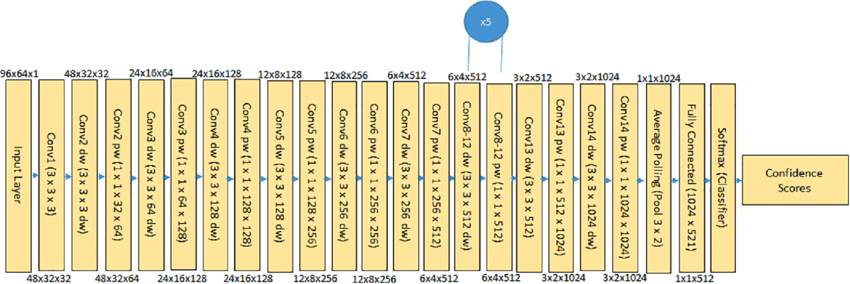

In [152]:
# Load the pre-trained YAMNet model
yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')

# Load and preprocess audio files
def load_audio(file_path, target_sr=16000):
    waveform, sr = librosa.load(file_path, sr=target_sr, mono=True)
    return waveform

audio_dir = '/content/sample_data/audios'

# Get list of audio files
audio_files = [os.path.join(audio_dir, f) for f in os.listdir(audio_dir) if f.endswith('.wav') or f.endswith('.mp3')]

# Load and preprocess the audio files
audio_data = [load_audio(file_path) for file_path in audio_files]

# Create labels based on file names
labels = []
for file in audio_files:
    if 'original' in file:
        labels.append(1)
    else:
        labels.append(0)

encoded_labels = np.array(labels)

# Function to extract embeddings using YAMNet
def extract_embeddings(audio_data):
    embeddings = []
    for waveform in audio_data:
        waveform_tensor = tf.convert_to_tensor(waveform, dtype=tf.float32)
        scores, embedding, spectrogram = yamnet_model(waveform_tensor)
        embeddings.append(embedding.numpy().mean(axis=0))  # Average over time
    return np.array(embeddings)

# Extract features from the audio data using YAMNet
features = extract_embeddings(audio_data)

# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(features, encoded_labels, test_size=0.5, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Scale the features
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Print dataset sizes
train_size = len(X_train_scaled)
val_size = len(X_val_scaled)
test_size = len(X_test_scaled)
print(f'Train dataset size: {train_size}')
print(f'Validation dataset size: {val_size}')
print(f'Test dataset size: {test_size}')

# Function to create the model
def create_model():
    input_audio = layers.Input(shape=(1024,))  # YAMNet embeddings are 1024-dimensional
    x = layers.Dense(128, activation='relu')(input_audio)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=input_audio, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create and summarize the model
model = create_model()
model.summary()

# Train the model
model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, validation_data=(X_val_scaled, y_val))

# Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f'Test accuracy: {accuracy:.2f}')

# Save the model
model.save('audio_classifier_model.keras')

Train dataset size: 6
Validation dataset size: 3
Test dataset size: 3


Model: "functional_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 139,521 (545.00 KB)

 Trainable params: 139,521 (545.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5000 - loss: 2.7750 - val_accuracy: 0.6667 - val_loss: 0.8736
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.8333 - loss: 0.3237 - val_accuracy: 0.6667 - val_loss: 0.8681
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 1.0000 - loss: 0.1621 - val_accuracy: 0.6667 - val_loss: 0.9200
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.8333 - loss: 6.0264 - val_accuracy: 0.6667 - val_loss: 0.9100
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.6667 - loss: 16.4880 - val_accuracy: 0.6667 - val_loss: 0.8106
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 1.0000 - loss: 0.0872 - val_accuracy: 0.6667 - val_loss: 0.7467
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.8333 - loss: 23.8364 - val_accuracy: 0.6667 - val_loss: 0.6825
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.8333 - loss: 0.1968 - val_accuracy: 0.6667 - val_loss: 

Predict Label of A New Audio

In [154]:
uploaded = files.upload()
audio_file = list(uploaded.keys())[0]

uploaded_audio_data = load_audio(audio_file)

# Extract embeddings from the uploaded audio data using YAMNet
uploaded_waveform_tensor = tf.convert_to_tensor(uploaded_audio_data, dtype=tf.float32)
_, uploaded_embedding, _ = yamnet_model(uploaded_waveform_tensor)
uploaded_embedding = uploaded_embedding.numpy().mean(axis=0)

predictions = model.predict(np.array([uploaded_embedding]))

if predictions[0][0] > 0.5:
    print("Predicted label: Real")
else:
    print("Predicted label: Fake")

Saving linus-original-DEMO.mp3 to linus-original-DEMO (1).mp3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted label: Real
